%reset

In [115]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [116]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import scipy as sp
import scipy.sparse.linalg
import time
from scipy import interpolate

plt.rcParams["figure.figsize"] = (8,8)

from RHS_for_v import *

In [117]:
from importlib import reload

R_max=1
L=1
s_points=100
r_points=100
Rv=0.05
D=1
K_eff=5
inner_modification=False
my_west_mode=True
sour="cosine"

In [158]:
obj_fine=simplified_assembly_Laplacian_cylindrical(R_max, Rv,r_points,s_points, L, D)
f_hs, f_hr=obj_fine.inc_s, obj_fine.inc_r
Lap_operator=obj_fine.assembly().toarray()

f_r=obj_fine.r
f_s=obj_fine.s

In [119]:
if sour=="cosine":
    #Set an analytical source profile
    q_vessel=np.cos(obj_fine.s/(L*0.7))
    q_first=-(1/(L*0.7))*np.sin(obj_fine.s/(L*0.7))
    q_sec=-np.cos(obj_fine.s/(L*0.7))*(1/(L*0.7))**2
if sour=="constant":
    q_vessel=np.zeros(len(obj_fine.s))+1
    q_first=q_vessel-1
    q_sec=q_vessel-1

In [120]:
#Set Dirichlet on the outer boundary
ext_boundary=np.concatenate([[obj_fine.corners[2]], obj_fine.outer_boundary, [obj_fine.corners[3]]])
Lap_operator[obj_fine.outer_boundary,:]=0
Lap_operator[obj_fine.outer_boundary,obj_fine.outer_boundary]=1

In [121]:
sing_sing_fine=np.outer(Green(obj_fine.r, Rv), q_vessel)
sol_real_fine=get_RHS_validation(Lap_operator,q_vessel, Rv, obj_fine.inc_r,obj_fine.inc_s, D, ext_boundary)
v_real_fine=sol_real_fine-sing_sing_fine
rhs_real_fine=Lap_operator.dot(np.ndarray.flatten(v_real_fine))
RHS_real_fine=rhs_real_fine.reshape(len(f_r), len(f_r))

In [122]:
#Coarse_solution
coarse_r_points=10
coarse_s_points=10


#Let's create the Laplacian operator with the proper boundary conditions (Dirichlet north and 
#no flux east and west)
obj_coarse=simplified_assembly_Laplacian_cylindrical(R_max, Rv,coarse_r_points,coarse_s_points, L, D)
coarse_Lap=obj_coarse.assembly().toarray()

c_r=obj_coarse.r
c_s=obj_coarse.s
c_hs=obj_coarse.inc_s
c_hr=obj_coarse.inc_r

obj_RHS=get_coarse_RHS_v(obj_coarse, obj_fine, q_vessel, q_sec, q_first, coarse_Lap)


total_no_ghost=coarse_r_points*coarse_s_points
obj_RHS.seg_north_with_ghost()
RHS_split_coarse=obj_RHS.get_east_west_RHS()
RHS_split_coarse+=np.ndarray.flatten(obj_RHS.get_RHS_v())
RHSghost_split_coarse=obj_RHS.RHS_ghost
RHSghost_split_coarse[:total_no_ghost]=RHS_split_coarse

            
v_split_coarse=np.linalg.solve(obj_RHS.ghost_coarse_Lap,RHSghost_split_coarse)
vghost_split_coarse=v_split_coarse[:total_no_ghost]

f = interpolate.interp2d(obj_RHS.ghost_coarse.s,obj_RHS.ghost_coarse.r[:-1] , vghost_split_coarse.reshape(len(obj_RHS.ghost_coarse.r[:-1]), len(obj_RHS.ghost_coarse.s)), kind='linear')
vghost_split_interp=f(f_r, f_s)

COUPLED PROBLEM

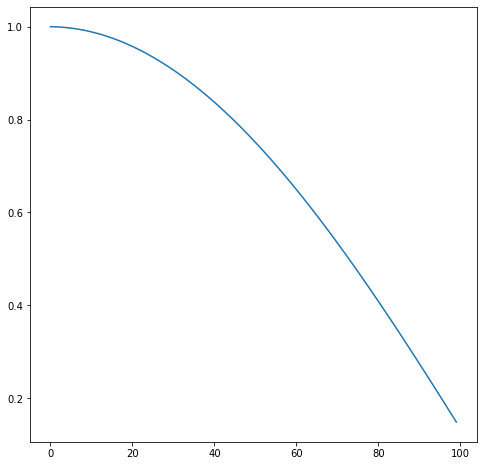

In [123]:
plt.plot(q_vessel)

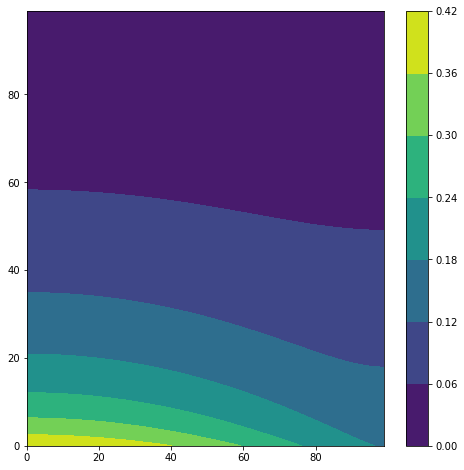

In [125]:
plt.contourf(sol_real_fine); plt.colorbar()

sing_sing_fine=np.outer(Green(obj_fine.r, Rv), q_vessel)
sol_real_fine=get_RHS_validation(Lap_operator,q_vessel, Rv, obj_fine.inc_r,obj_fine.inc_s, D, ext_boundary)
v_real_fine=sol_real_fine-sing_sing_fine
rhs_real_fine=Lap_operator.dot(np.ndarray.flatten(v_real_fine))
RHS_real_fine=rhs_real_fine.reshape(len(f_r), len(f_r))

In [150]:
#Lap fine, with Dirichlet norht -> Lap_operator, f_s, f_r, 

inner_boundary=np.concatenate([[obj_fine.corners[0]],obj_fine.inner_boundary, [obj_fine.corners[1]]])


In [151]:
def get_RHS_validation_coupled(Lap_operator,phi_vessel, Rv, inc_r, inc_s, D, ext_boundary,K_eff):
    """modifies the lap_operator and the RHS in order to accomodate the incomming flux"""
    RHS=np.zeros(Lap_operator.shape[0])
    factor=(K_eff*np.pi*Rv**2)/(D*np.pi*(2*Rv+inc_r)*inc_r)
    #factor=(K_eff*np.pi*Rv**2)/(2*np.pi*(Rv+inc_r/2)*inc_r)
    print(factor)
    i=np.arange(len(q_vessel))
    RHS[i]=-factor*q_vessel
    
    RHS[ext_boundary]=0
    Lap_operator[ext_boundary,:]=0
    Lap_operator[ext_boundary, ext_boundary]=1  
    
    #Lap_operator[i,i]-=factor
    
    sol=np.linalg.solve(Lap_operator, RHS)
    lenr=len(RHS)/len(q_vessel)
    return(sol.reshape(int(lenr), len(q_vessel)))

In [152]:
obj_coupled=simplified_assembly_Laplacian_cylindrical(R_max, Rv,r_points,s_points, L, D)
f_hs, f_hr=obj_coupled.inc_s, obj_coupled.inc_r
Lap_coupled=obj_fine.assembly().toarray()

f_r=obj_fine.r
f_s=obj_fine.s


ext_boundary=np.concatenate([[obj_fine.corners[2]], obj_fine.outer_boundary, [obj_fine.corners[3]]])

In [153]:
if sour=="cosine":
    #Set an analytical source profile
    q_vessel=np.cos(obj_fine.s/(L*0.7))
    q_first=-(1/(L*0.7))*np.sin(obj_fine.s/(L*0.7))
    q_sec=-np.cos(obj_fine.s/(L*0.7))*(1/(L*0.7))**2
if sour=="constant":
    q_vessel=np.zeros(len(obj_fine.s))+1
    q_first=q_vessel-1
    q_sec=q_vessel-1

In [154]:
K_eff=1/(np.pi*Rv**2)
sol_real_fine_coupled=get_RHS_validation_coupled(Lap_operator,q_vessel, Rv,obj_coupled.inc_r, obj_coupled.inc_s, D, ext_boundary,K_eff)

302.66846417534157


127.32395447351627


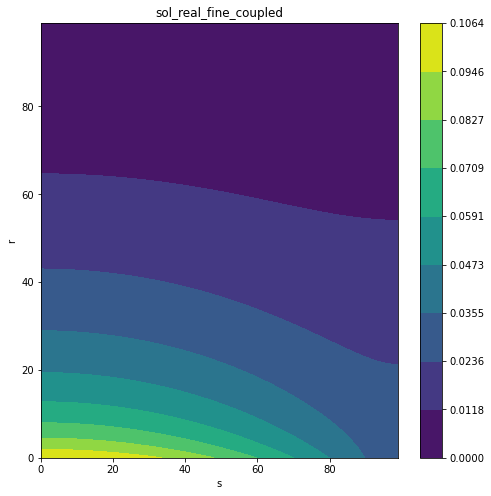

In [155]:
print(K_eff)
plott(sol_real_fine_coupled, "sol_real_fine_coupled",0,np.max(sol_real_fine_coupled))


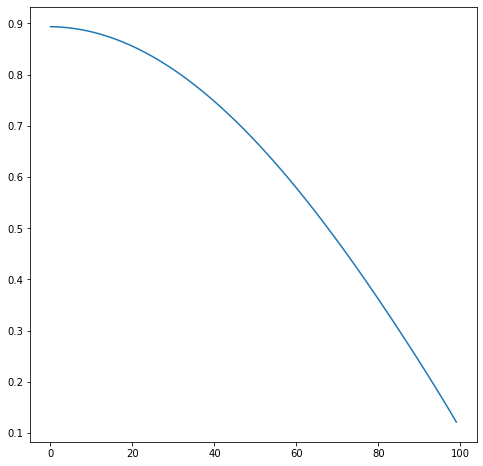

In [156]:
coupled_q_vessel_fine=np.pi*Rv**2*K_eff*(q_vessel-sol_real_fine_coupled[0,:])
plt.plot(coupled_q_vessel_fine)

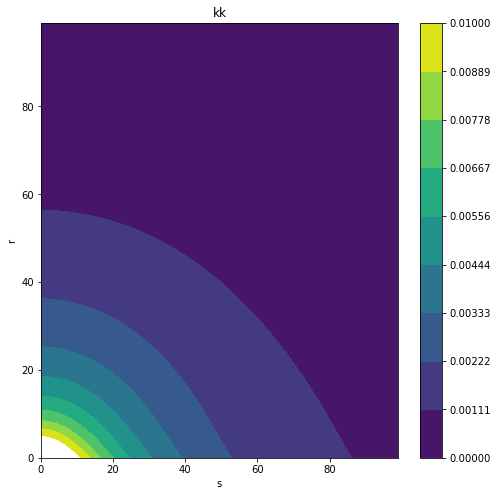

In [164]:
plott(get_RHS_validation(Lap_operator,coupled_q_vessel_fine, Rv, f_r, f_s, D, ext_boundary),"kk",0,0.01)

In [163]:
np.max(get_RHS_validation(Lap_operator,coupled_q_vessel_fine, Rv, f_r, f_s, D, ext_boundary))

0.017738070961618828